- https://albertauyeung.github.io/2017/04/23/python-matrix-factorization.html

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import boxcox, inv_boxcox
from scipy import stats

from recommenderSystem import RecSys

# Datios Intelia

In [2]:
!ls data

customers.csv  products.csv  relation.csv


In [3]:
dataPath = "data/"

users = pd.read_csv(dataPath + "customers.csv")
items = pd.read_csv(dataPath + "products.csv")
pairs = pd.read_csv(dataPath + "relation.csv")

/tmp/ipykernel_734/3077265193.py:3: DtypeWarning: Columns (7,9,10,11,12,13,17,18,21,26,27,28,30,36) have mixed types. Specify dtype option on import or set low_memory=False.
  users = pd.read_csv(dataPath + "customers.csv")
/tmp/ipykernel_734/3077265193.py:4: DtypeWarning: Columns (20,32,34,39) have mixed types. Specify dtype option on import or set low_memory=False.
  items = pd.read_csv(dataPath + "products.csv")


# Compañía 39

In [4]:
pairs = pairs[ pairs.company_id == 39].copy()
users = users[ users.company_id == 39].copy()
items = items[ items.company_id == 39].copy()

In [5]:
pairs.sample(4)

,company_id,product_id,customer_id,compras,visto,peso,ultimo
390857,39,123739,346096,1,0,3.0,2022-05-30 00:00:00
563171,39,123853,393879,1,0,3.0,2019-06-16 00:00:00
492457,39,123772,334706,1,0,3.0,2022-05-16 00:00:00
549508,39,123810,372819,1,0,3.0,2021-11-15 00:00:00


# Definir peso usuario-producto

Mean: 2.6374847227984537
Median: 2.5
Std: 0.4235406584234164


<AxesSubplot:ylabel='Frequency'>

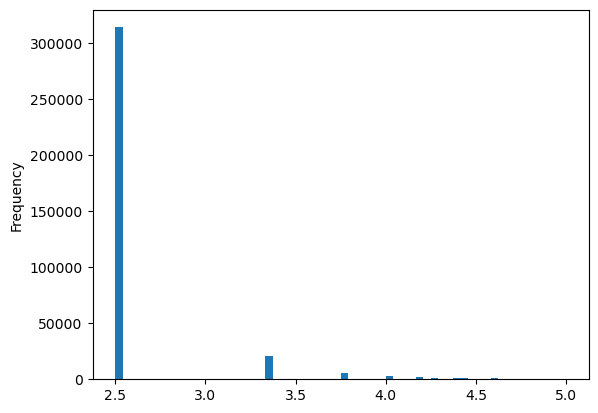

In [6]:
def funcRacional_visitas(x):
    return (1 * x) / (x + 5)

def funcRacional_compras(x):
    return (5 * x) / (x + 1)

def getPeso(col_compras, col_visitias):
    return funcRacional_compras(col_compras + funcRacional_visitas(col_visitias) ).copy()

pairs["peso"] = getPeso(pairs["compras"], pairs["visto"])

print("Mean:",   pairs["peso"].mean())
print("Median:", pairs["peso"].median())
print("Std:",    pairs["peso"].std())

pairs["peso"].plot.hist(bins=60)

In [7]:
rs = RecSys(pairs, users, items, userName="customer_id", itemName="product_id", scoreName="peso")
#rs.draw_matrix()

## Train with fast.ai

In [8]:
from fastai.tabular.all import *
from fastai.collab import *

dls = CollabDataLoaders.from_df(ratings=pairs,
                                valid_pct=0.2,
                                user_name="customer_id",
                                item_name="product_id",
                                rating_name="peso",
                                seed=None,
                                bs=64)

learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5), metrics=[mae])
learn.fit_one_cycle(5, 0.005, wd=0.1)

epoch,train_loss,valid_loss,mae,time
0,0.440148,0.427594,0.446268,00:02
1,0.324461,0.358758,0.403902,00:02
2,0.193563,0.357401,0.420960,00:02
3,0.107943,0.348195,0.396593,00:02
4,0.057671,0.349214,0.400716,00:02


## Train with my module

In [9]:
split_idx = int(len(rs.samples) * 0.8)
#np.random.shuffle(self.samples)
train_samples = rs.samples[:split_idx]
valid_samples = rs.samples[split_idx:]

train_log = rs.entrenar_modelo_manualmente(
    train_samples = train_samples,
    valid_samples = valid_samples,
    embSize = 50,
    lr = 0.01,
    wd = 0.1,
    epochs=50)

Epoch: 1 ; trMAE = 0.2764 trMSE = 0.2481 valMAE = 0.5080 valMSE = 0.5370
Epoch: 2 ; trMAE = 0.2767 trMSE = 0.2325 valMAE = 0.5001 valMSE = 0.5209
Epoch: 3 ; trMAE = 0.2751 trMSE = 0.2237 valMAE = 0.4942 valMSE = 0.5103
Epoch: 4 ; trMAE = 0.2727 trMSE = 0.2172 valMAE = 0.4900 valMSE = 0.5022
Epoch: 5 ; trMAE = 0.2717 trMSE = 0.2125 valMAE = 0.4883 valMSE = 0.4994
Epoch: 6 ; trMAE = 0.2709 trMSE = 0.2085 valMAE = 0.4872 valMSE = 0.4957
Epoch: 7 ; trMAE = 0.2710 trMSE = 0.2053 valMAE = 0.4842 valMSE = 0.4903
Epoch: 8 ; trMAE = 0.2711 trMSE = 0.2028 valMAE = 0.4839 valMSE = 0.4887
Epoch: 9 ; trMAE = 0.2705 trMSE = 0.2004 valMAE = 0.4855 valMSE = 0.4904
Epoch: 10 ; trMAE = 0.2732 trMSE = 0.1988 valMAE = 0.4837 valMSE = 0.4862
Epoch: 11 ; trMAE = 0.2684 trMSE = 0.1965 valMAE = 0.4841 valMSE = 0.4877
Epoch: 12 ; trMAE = 0.2695 trMSE = 0.1950 valMAE = 0.4824 valMSE = 0.4846
Epoch: 13 ; trMAE = 0.2702 trMSE = 0.1935 valMAE = 0.4833 valMSE = 0.4855
Epoch: 14 ; trMAE = 0.2678 trMSE = 0.1923 valMA

KeyboardInterrupt: 

In [10]:
#rs.plot_training(train_log)